# HELICITY FOR DIFFERENT SYSTEMS

## New trajectories without the sc(i)-mc(i-4) hyrogen bond

#### Here, we want to check either if the helicity evolution change or not when we are only considering the trajectory frames where this bond doesn't occur. 

In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import mdtraj as md
import seaborn as sns
#from scipy.stats import gaussian_kde
import pandas as pd
from Bio.SeqUtils import IUPACData

In [148]:
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools 
from itertools import product
import mdtraj.testing

In [227]:
def calc_Helicity_non_H_bonds(dirname, temp=1,equil=0):
    """
    Calculate the helicity from a trajectory not taking into consideration the frames where the distance between
    sc(i)-mc(i+4) bond is less than 2.3A
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    #print (t)
    #These are the potential donor atom names.
    #Selecting the hydrogens of Q1
    donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors.size==0: return np.array([9999.])
    #Selecting the oxigen of L1
    acceptor = t.topology.select('residue 7 and name O')
    pairs = list(product(donors, acceptor))
    #calculating the distances between these 2 atoms
    d = md.compute_distances(t, pairs)
    #We take the shortest distance
    d = d.min(1)
    d *= 10 #to angstroms
    #Creating a new trajectory with only the frames don't making a H-bond
    t1 = t[d>2.5]
    ss = md.compute_dssp(t1)
    return ss =='H', ss =='C'

def calc_H_bonds(dirname, temp=1,equil=0):
    """
    Calculate the H_bonds between Q1 and L1.
    In fact this just returns the distance not the H-bond.
    """
    from itertools import product
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    print (t)
    #These are the potential donor atom names.
    #Selecting the hydrogens of Q1
    donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors.size==0: return np.array([9999.])
    #Selecting the oxigen of L1
    acceptor = t.topology.select('residue 7 and name O')
    pairs = list(product(donors, acceptor))
    d = md.compute_distances(t, pairs)
    #We take the shortest distance
    d = d.min(1)
    d *= 10 #to angstroms
    t1 = t[d>2.5]
    donors2 = t1.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors2.size==0: return np.array([9999.])
    #Selecting the oxigen of L1
    acceptor2 = t1.topology.select('residue 7 and name O')
    pairs2 = list(product(donors2, acceptor2))
    new_d = md.compute_distances(t1, pairs2)
    new_d = new_d.min(1)
    new_d *= 10
    return new_d


def calc_helicity(dirname, temp=1,equil=0):
    """
    Calculate the helicity from a trajectory
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    print (t)
    ss = md.compute_dssp(t)
    return ss =='H', ss =='C'


def get_residues(dirname):
    """
    Return the residue list from the topology
    """
    topname = os.path.join(dirname, 'prot.pdb')
    t = md.load(topname, stride=1)
    return list(t.top.residues)


def plot_helicity(helix, residues, blocks=5, equil=0, **kwargs):
    """
    Plot the helicity from an array of (N,M) of calculated helicities 
    """
    #Remove equilibration
    helix = helix[equil:]
    n_frames = helix.shape[0]
    step = n_frames//blocks
    values = [helix[i*step:(i+1)*step].mean(0) for i in range(blocks)]
    #df=pd.DataFrame(values, columns=[s+str(i) for i,s in enumerate('KKPGASLLLL'+12*'Q'+'KK')]).T
    #df=pd.DataFrame(values, columns=[s for s in 'KKPGASLLLL'+12*'Q'+'KK']).T
    df=pd.DataFrame(values).T
    df =df.unstack().reset_index()
    df.columns=['repetion', 'residue', 'helicity']
    ax=sns.lineplot(x='residue', y='helicity', data=df, sort=False, **kwargs)
    #plt.xticks(np.arange(helix[name].shape[1]), 'KKPGASLLLL'+12*'Q'+'KK')
    #ax.set_xticks(np.arange(helix.shape[1]) )
    #ax.set_xticklabels('KKPGASLLLL'+12*'Q'+'KK')
    ax.grid(True)
    plt.legend()
    plt.ylim(None, 1.)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues])
    plt.xticks(np.arange(helix.shape[1]), ticks)
   

#### Helicity (without the sc-mc hydrogen bond) 

In [234]:
helix1 = {}
coil1 = {}
residues1 = {}
system_list1 = ('A4_Q12_DES-amber','L4_Q8_DES-amber','L4_Q12_DES-amber','Q1EH_DES-amber')
for system in system_list1: 
    path1 = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #equil is the equilibration time, which is discarded
    #tupple formed by H (0) and C (1) 
    helix1[system],coil1[system] = calc_Helicity_non_H_bonds(path1, equil=0)
    #Print the length of the trajectory
    print('{:60s} -- {:5d}'.format(path1, helix1[system].shape[0]))
    residues1[system] = get_residues(path1)



/home/lourdes/TFM-LOURDES/data/ALL/A4_Q12_DES-amber          -- 19862
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q8_DES-amber           -- 19490
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_DES-amber          -- 19214
/home/lourdes/TFM-LOURDES/data/ALL/Q1EH_DES-amber            -- 19740


In [235]:
helix2 = {}
coil2 = {}
residues2 = {}
path2 = f'/home/lourdes/TFM-LOURDES/data/ALL/Q1E_DES-amber'
helix2,coil2 = calc_helicity (path2, equil=0)
residues2 = get_residues(path2)
print ('{:60s} -- {:5d}'.format(path2, len(helix2)))

<mdtraj.Trajectory with 18877 frames, 411 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1E_DES-amber             -- 18877


## Results 

### Helicity Evolution

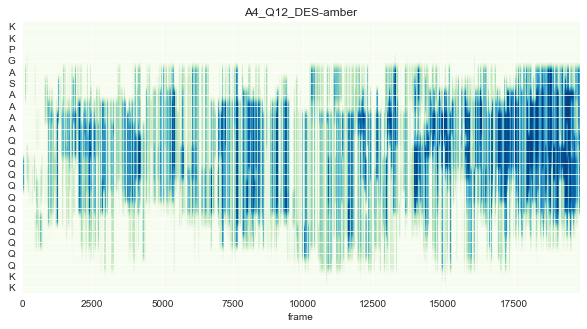

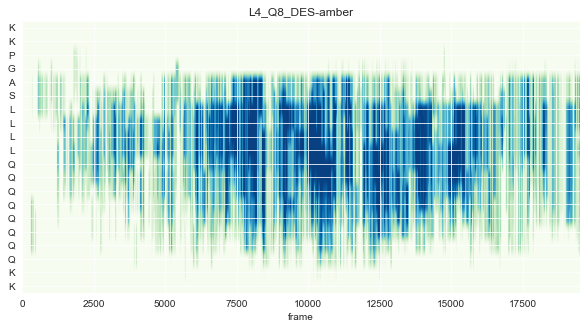

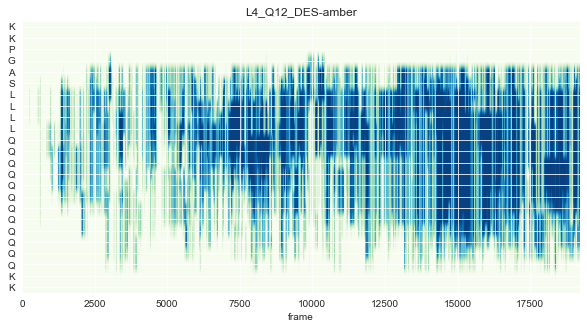

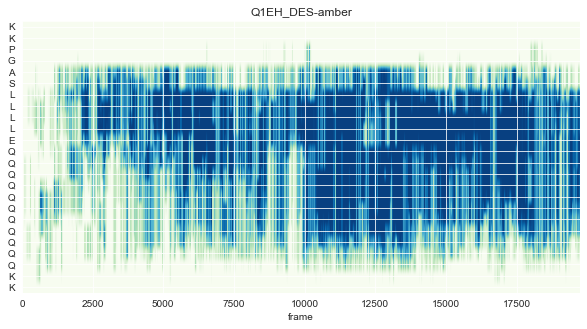

In [236]:
for name in helix1:
    plt.figure(name, figsize=(10,5))
    plt.imshow(helix1[name].T, aspect='auto',cmap='GnBu')
    plt.xlabel('frame')
    plt.title(name)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues1[name]])
    plt.yticks(np.arange(helix1[name].shape[1]), ticks)



([<matplotlib.axis.YTick at 0x7f46489d52e0>,
 [Text(0, 0, 'K'),
  Text(0, 1, 'K'),
  Text(0, 2, 'P'),
  Text(0, 3, 'G'),
  Text(0, 4, 'A'),
  Text(0, 5, 'S'),
  Text(0, 6, 'L'),
  Text(0, 7, 'L'),
  Text(0, 8, 'L'),
  Text(0, 9, 'L'),
  Text(0, 10, 'E'),
  Text(0, 11, 'Q'),
  Text(0, 12, 'Q'),
  Text(0, 13, 'Q'),
  Text(0, 14, 'Q'),
  Text(0, 15, 'Q'),
  Text(0, 16, 'Q'),
  Text(0, 17, 'Q'),
  Text(0, 18, 'Q'),
  Text(0, 19, 'Q'),
  Text(0, 20, 'Q'),
  Text(0, 21, 'Q'),
  Text(0, 22, 'K'),
  Text(0, 23, 'K')])

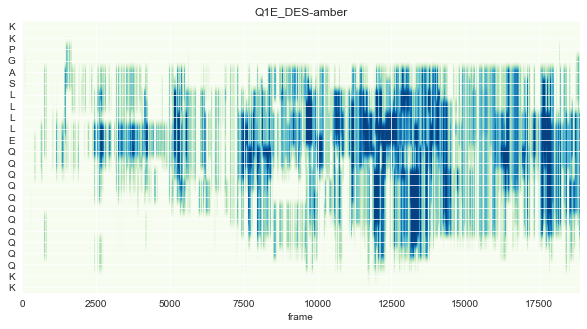

In [237]:
plt.figure(figsize=(10,5))
plt.imshow(helix2.T, aspect='auto',cmap='GnBu')
plt.xlabel('frame')
plt.title('Q1E_DES-amber')
#ticks=''.join([IUPACData.protein_letters_3to1[r.helix2.title()] for r in residues2])
plt.yticks(np.arange(helix2.shape[1]), ticks)

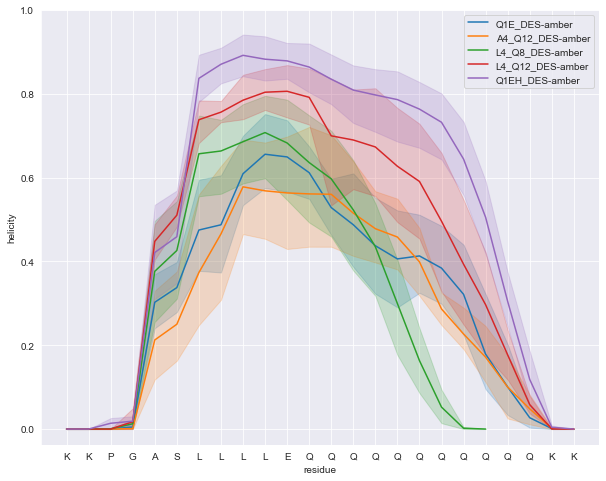

In [238]:
plt.figure(figsize=(10,8))
plot_helicity(helix2,residues2,label='Q1E_DES-amber', equil=7000)
for name in helix1:
    #uncomment for separate plots
    #plt.figure(figsize=(10,7))
    plot_helicity(helix1[name], residues1[name], label=name, equil=7000)


<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
[10.366124 11.201014 10.165242 ...  5.839984  5.630391 16.295822]
<mdtraj.Trajectory with 20001 frames, 345 atoms, 20 residues, and unitcells>
[10.982624  11.933006  11.793871  ...  6.4073486  6.6929293  6.447891 ]
<mdtraj.Trajectory with 24283 frames, 413 atoms, 24 residues, and unitcells>
[10.425224   7.7151914  9.125453  ... 14.332157   3.908056  13.507393 ]
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
[11.378583  12.298135  11.752719  ...  7.3520813  2.5245     3.5772612]


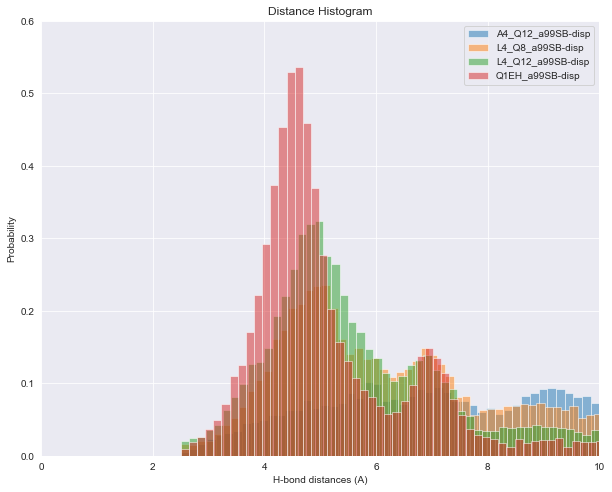

In [233]:
H_bonds = {}

plt.figure(figsize=(10,8))

for system in system_list1: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    H_bonds[system] = calc_H_bonds(path, equil=0)           
    print (H_bonds[system])
    
    num_bins = 100
   
    # the histogram of the data
    N, bins, patches = plt.hist(H_bonds[system], bins=num_bins, density=True, label=system, alpha=0.5)

    plt.axis([0,10,0,0.6])
    plt.xlabel('H-bond distances (A)')
    plt.ylabel('Probability')
    plt.title(r'Distance Histogram')
    plt.legend()
    
    #plt.show()
    sns.set_style('darkgrid')
    